In [1]:
import sys

sys.path.append("../../..")

import numpy as np
import pandas as pd
from scipy import optimize
import matplotlib.pyplot as plt
from matplotlib import rc
import mpl_toolkits.axes_grid1.inset_locator as inloc
import scipy.stats as stats
import src.energy_effects_t2k.convolution as conv
import src.nu_osc.osc_prob as osc
import src.nu_osc.default_parameters as param

/local/home/pb278543/Github/energy-effects-T2K/docs/source/notebooks/../../../src/energy_effects_t2k/convolution.py:614: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if chanel is not '':


In [2]:
rc("figure", figsize=(10, 5))
# rc('lines', linewidth=2)
rc("axes", labelsize=12, linewidth=1, grid=True, labelpad=-1, axisbelow=True)
rc("axes.spines", right=True)
rc("xtick", direction="in", labelsize=12, top=True)
rc("xtick.major", width=0.8, size=5)
rc("ytick", direction="in", labelsize=12, right=True)
rc("ytick.major", width=0.8, size=5)
rc("legend", fancybox=False, fontsize=12, shadow=False)
rc(
    "grid",
    linewidth=1.0,
)  # ls='dotted')
# import matplotlib_inline
# matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [3]:
t2kflux_2020_plus250kA_nominal_sk = conv.fluximport(
    "t2kflux_2020_plus250kA_nominal_sk.csv"
)

In [4]:
ccqe_interp = conv.xsecimport(
    name="neutrino_ccqe.csv",
    mode="true filter interp",
    keep_left=5,
    on=(t2kflux_2020_plus250kA_nominal_sk.minE + t2kflux_2020_plus250kA_nominal_sk.maxE)
    / 2,
)

In [5]:
ccqe_energy_res_interp = conv.energyimport(
    name="ccqe_energy_res.csv", mode="interp", on=np.linspace(-0.5, 1.0, 125)
)

In [6]:
number = pd.DataFrame()
for key in ["minE", "maxE"]:
    number[key] = t2kflux_2020_plus250kA_nominal_sk[key]
for key in ["numu", "antinumu", "nue", "antinue"]:
    number[key] = (
        (ccqe_interp.xsec * t2kflux_2020_plus250kA_nominal_sk[key] / (50 * 1e21))
        * param.SK_POT
        * param.TOT_NEUTRONS
        * 2
    )
number["nutau"] = 0.0
number["antinutau"] = 0.0

In [7]:
number_oscillated = {
    "bf": conv.oscillate(to_oscillate=number),
    "p1sigma": conv.oscillate(
        to_oscillate=number, delta_cp=param.NUFIT["delta_CP"]["p1sigma"]
    ),
    "m1sigma": conv.oscillate(
        to_oscillate=number, delta_cp=param.NUFIT["delta_CP"]["m1sigma"]
    ),
    "p3sigma": conv.oscillate(
        to_oscillate=number, delta_cp=param.NUFIT["delta_CP"]["p3sigma"]
    ),
    "m3sigma": conv.oscillate(
        to_oscillate=number, delta_cp=param.NUFIT["delta_CP"]["m3sigma"]
    ),
}

oscillated_smeared = {}
for key in number_oscillated:
    oscillated_smeared[key] = conv.convolve(
        input=number_oscillated[key], gate=ccqe_energy_res_interp
    )

params = {
    "delta_cp": [param.NUFIT["delta_CP"]["m3sigma"], param.NUFIT["delta_CP"]["p3sigma"]]
}

number_oscillated["min"], number_oscillated["max"] = (
    number_oscillated["p3sigma"],
    number_oscillated["m3sigma"],
)
# conv.envelope(to_oscillate=number, params=params)
oscillated_smeared["min"], oscillated_smeared["max"] = (
    oscillated_smeared["p3sigma"],
    oscillated_smeared["m3sigma"],
)
# conv.envelope(
#    to_oscillate=number, params=params, gate=ccqe_energy_res_interp
# )

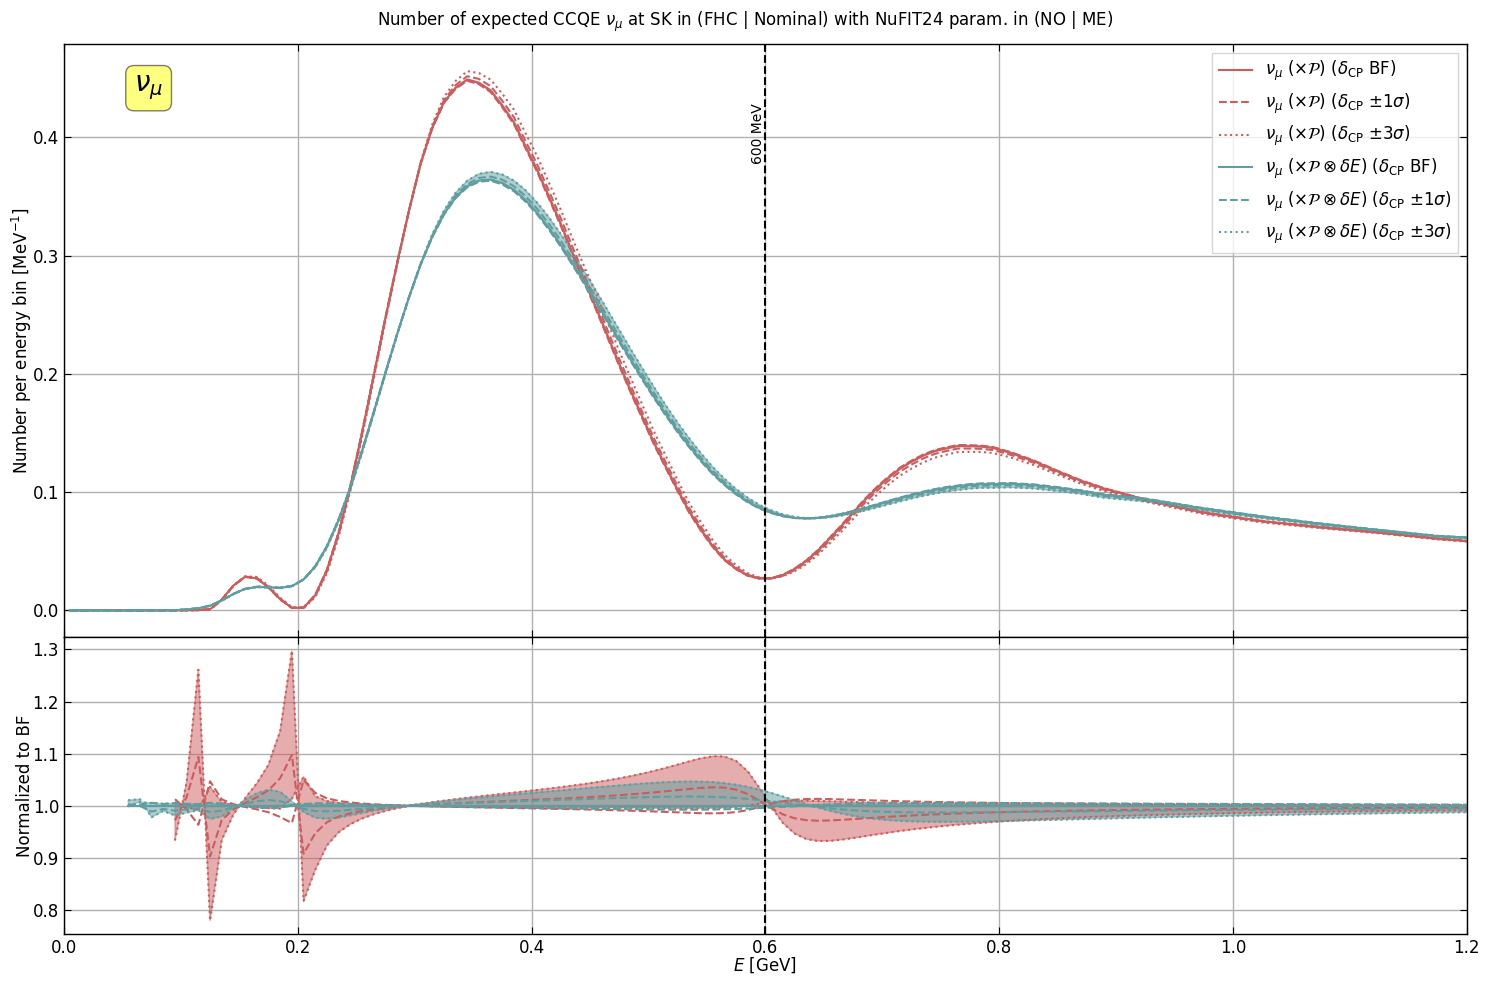

In [8]:
conv.oscillated_plot(
    number_oscillated=number_oscillated,
    oscillated_smeared=oscillated_smeared,
    params=params,
    channel=r"$\nu_\mu$",
)